# Loading Reuters Dataset and Packages
The Reuters data set is a collection of shrot newswires and their topic published in 1986. It's a widely used dataset for text classification. There are 46 different topics, some more represented than others. Ther eare at least 10 examples of each topic in the dataset.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import reuters
from keras import models, layers

We will load only the 10k most frequently used words in the data

In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2113536/2110848 [==============================] - 4s 2us/step


In [4]:
len(train_data), len(test_data)

(8982, 2246)

Each example in the dataset is a list of word integers (word indicies)

In [6]:
train_data[10][0:10]

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14]

In [11]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 1s 2us/step


The topics are numerical values from 0 to 45. The first example has topic 3.

In [12]:
train_labels[10]

3

# Encode the Data
To vectorize the labels the label list can be casted as an integer tensor, or with one-hot encodin.

One-hot encoding is used for categorical data, or categorical encoding.  In this case, one-hot encoding of labels consits of embedding each label as an all-zero vector with a 1 in the place of the label indx.

In [15]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
            results[i, sequence] = 1.
    return results

In [16]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [22]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [24]:
# There is also a built inway in Keras to one-hot-encode
# from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

# Building the Network
Topic classificataion is similar to the text-classification problem in the IMDB dataset. We re trying to classify short snippets of text. However, in this case there is a new constraint: the number of output classes has gone from 2 to 46-it's no longer binary.

In a stack of Dense layers, each layer can only access information present in the output of the previous layer. If one layer drops information relavent to the classfication probelem, this information can never be recovered by later layers. In essence, each layer can be an information bottleneck. To prevent this, increase the number of units in each layer. in the following example, we will uise dense layers with 64 units.

The final layer of the networks is a Dense layer of 46 units. This means for each input in the network, the network will output a 46-dimensional vector. Each entry in this vector will encode a different output class.

The last layers uses a softmax activation. The network will output a probability distribution over the 46 different output classes.

In [27]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

## Compiling the model

In [29]:
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

# Preparing the validationset

In [31]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

# Training the Network

In [33]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 120us/step - loss: 2.5241 - acc: 0.4977 - val_loss: 1.7183 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 68us/step - loss: 1.4443 - acc: 0.6889 - val_loss: 1.3496 - val_acc: 0.7090
Epoch 3/20
7982/7982 [==============================] - 1s 69us/step - loss: 1.0993 - acc: 0.7641 - val_loss: 1.1745 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 68us/step - loss: 0.8729 - acc: 0.8157 - val_loss: 1.0842 - val_acc: 0.7580
Epoch 5/20
7982/7982 [==============================] - 1s 69us/step - loss: 0.7061 - acc: 0.8492 - val_loss: 0.9869 - val_acc: 0.7830
Epoch 6/20
7982/7982 [==============================] - 1s 70us/step - loss: 0.5696 - acc: 0.8790 - val_loss: 0.9418 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 69us/step - loss: 0.4626 - acc: 0.9034 - val_loss: 0.9092 - val_acc: 0.8030
Epoch 

# Plotting the training and validation loss
We can see that the network begins to overfit after 9 epochs.

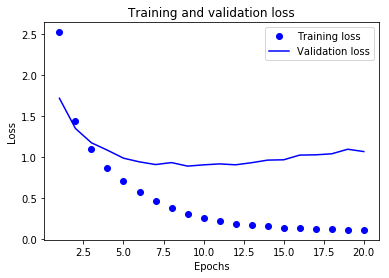

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

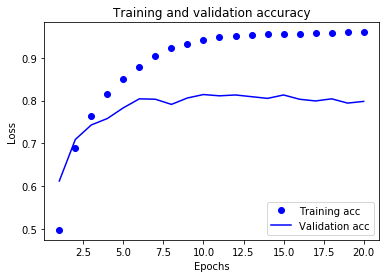

In [36]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Retraining a new network to prevent overfitting
We can see that the network has an accuracy of around 78.6%

In [39]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 100us/step - loss: 2.6135 - acc: 0.4644 - val_loss: 1.7289 - val_acc: 0.6350
Epoch 2/9
7982/7982 [==============================] - 1s 82us/step - loss: 1.4074 - acc: 0.7082 - val_loss: 1.2747 - val_acc: 0.7310
Epoch 3/9
7982/7982 [==============================] - 1s 72us/step - loss: 1.0425 - acc: 0.7786 - val_loss: 1.1035 - val_acc: 0.7630
Epoch 4/9
7982/7982 [==============================] - 1s 71us/step - loss: 0.8180 - acc: 0.8322 - val_loss: 1.0270 - val_acc: 0.7820
Epoch 5/9
7982/7982 [==============================] - 1s 84us/step - loss: 0.6507 - acc: 0.8629 - val_loss: 0.9513 - val_acc: 0.8070
Epoch 6/9
7982/7982 [==============================] - 1s 78us/step - loss: 0.5297 - acc: 0.8904 - val_loss: 0.9206 - val_acc: 0.8120
Epoch 7/9
7982/7982 [==============================] - 1s 73us/step - loss: 0.4213 - acc: 0.9113 - val_loss: 0.9006 - val_acc: 0.8140
Epoch 8/9
798

In [40]:
results

[0.9839374910797907, 0.7858414960459524]

This model reaches an accuracy close to around 80%. With a balanced binary classification problem, the accuracy reached by a random classifier would be 50%. In this case it's closer to 19%, so the results are pretty good compared to random.

Below we will randomly select a label to the data.

In [42]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.19056099732858414

# Generating predictions on new data
Each entry in predictions will be a vector of length 46

In [44]:
predictions = model.predict(x_test)

Ensure that it returns probability distribtion. Check to see if it sums to 1.

In [47]:
np.sum(predictions[0])

0.9999999

In [48]:
### The element with the largest value is the most probable result

In [49]:
np.argmax(predictions[0])

3

### Get all most probable values for the predictions
Below we print the first 10 predictions

In [51]:
predicted_labels = [np.argmax(i) for i in predictions]

In [53]:
predicted_labels[0:10]

[3, 10, 1, 4, 13, 3, 3, 3, 3, 3]

# Train another network, with a different loss function
In this case we will change the loss function from `categorical_crossentropy` to `sparse_categorical_crossentropy`. The difference is that
    * `categorical_crossentropy` takes one-hot encoded targets
    * `sparse_categorical_crossentropy` takes in integers
    
With this we get about 77.47% accuracy.

In [74]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
          train_labels,
          epochs=10,
          batch_size=100,
          validation_split = .1)

Train on 8083 samples, validate on 899 samples
Epoch 1/10
8083/8083 [==============================] - 1s 135us/step - loss: 1.7148 - acc: 0.6319 - val_loss: 1.2911 - val_acc: 0.7253
Epoch 2/10
8083/8083 [==============================] - 1s 88us/step - loss: 0.9044 - acc: 0.8081 - val_loss: 1.0858 - val_acc: 0.7575
Epoch 3/10
8083/8083 [==============================] - 1s 107us/step - loss: 0.5895 - acc: 0.8718 - val_loss: 0.9961 - val_acc: 0.7976
Epoch 4/10
8083/8083 [==============================] - 1s 90us/step - loss: 0.4004 - acc: 0.9146 - val_loss: 0.9791 - val_acc: 0.8042
Epoch 5/10
8083/8083 [==============================] - 1s 92us/step - loss: 0.2906 - acc: 0.9339 - val_loss: 1.0098 - val_acc: 0.8109
Epoch 6/10
8083/8083 [==============================] - 1s 92us/step - loss: 0.2244 - acc: 0.9488 - val_loss: 1.0323 - val_acc: 0.8009
Epoch 7/10
8083/8083 [==============================] - 1s 87us/step - loss: 0.1919 - acc: 0.9514 - val_loss: 1.0999 - val_acc: 0.7953
Epoch 

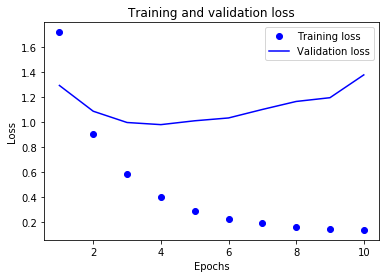

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

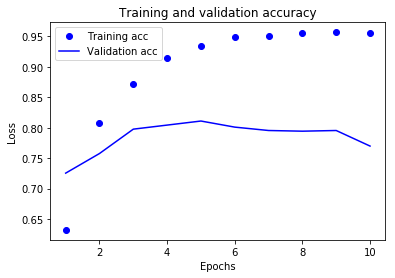

In [76]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [77]:
results = model.evaluate(x_test, test_labels)

2246/2246 [==============================] - 0s 75us/step


In [78]:
results

[1.2881010249588813, 0.7747105966692829]